## Imports

In [1]:
import os
import re
import glob
import json
import string
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
%matplotlib inline

## Read & Combine Data

### LinkedIn Job Postings

In [2]:
listings_li = pd.read_csv("./Kaggle-Data-Science-ML-Survey-Analysis/data/raw/job_listings/MLE Jobs LinkedIn.csv")
listings_li.head(3)

,Unnamed: 0,Job Title,Company Name,Location,Work Mode,Employment Type,Company Headcount,Industry,JD,JobID
0,0,SENIOR COMPUTER VISION DATA SCIENTIST,80 Acres Farms,"Hamilton, OH",On-site,Full-time · Mid-Senior level,201-500 employees,Farming,About The Company\r\n\r\nThe Future of Fresh i...,3331975665
1,1,Senior Software Engineer,Terran Robotics,"Bloomington, IN",Hybrid,Full-time,1-10 employees,None,Terran Robotics is building construction robot...,2841811846
2,2,Systems Engineer,ZF Group,Greater Lansing,Hybrid,Full-time · Mid-Senior level,"10,001+ employees",Motor Vehicle Manufacturing,Job description:\r\n\r\nJob Description:\r\n\r...,3369017400


### Glassdoor Job Postings

In [3]:
path_folder = "./Kaggle-Data-Science-ML-Survey-Analysis/data/raw/job_listings"
paths_csv = glob.glob(os.path.join(path_folder, "*.csv"))
paths_csv

['./Kaggle-Data-Science-ML-Survey-Analysis/data/raw/job_listings/MLE Jobs LinkedIn.csv',
 './Kaggle-Data-Science-ML-Survey-Analysis/data/raw/job_listings/DataScientist.csv',
 './Kaggle-Data-Science-ML-Survey-Analysis/data/raw/job_listings/DataAnalyst.csv',
 './Kaggle-Data-Science-ML-Survey-Analysis/data/raw/job_listings/DataEngineer.csv',
 './Kaggle-Data-Science-ML-Survey-Analysis/data/raw/job_listings/BusinessAnalyst.csv']

In [4]:
cols = ['Job Title',
         'Salary Estimate',
         'Job Description',
         'Rating',
         'Company Name',
         'Location',
         'Headquarters',
         'Size',
         'Founded',
         'Type of ownership',
         'Industry',
         'Sector',
         'Revenue',
         'Competitors',
         'Easy Apply']

In [5]:
listings_gd = pd.DataFrame()

for file in paths_csv:
    if "MLE Jobs LinkedIn" in file:
        continue
        
    jobfamily = file.split("/")[-1].split(".csv")[0] # Extract job family from file path
    print(jobfamily)
    
    df = pd.read_csv(file)
    df = df[cols] # Reorder & subset cols for data integrity
    listings_gd = pd.concat([listings_gd, df], axis=0, ignore_index=True)

del df
listings_gd.head(3)

DataScientist
DataAnalyst
DataEngineer
BusinessAnalyst


,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,Senior Data Scientist,$111K-$181K (Glassdoor est.),"ABOUT HOPPER\n\nAt Hopper, we’re on a mission ...",3.5,Hopper\n3.5,"New York, NY","Montreal, Canada",501 to 1000 employees,2007,Company - Private,Travel Agencies,Travel & Tourism,Unknown / Non-Applicable,-1,-1
1,"Data Scientist, Product Analytics",$111K-$181K (Glassdoor est.),"At Noom, we use scientifically proven methods ...",4.5,Noom US\n4.5,"New York, NY","New York, NY",1001 to 5000 employees,2008,Company - Private,"Health, Beauty, & Fitness",Consumer Services,Unknown / Non-Applicable,-1,-1
2,Data Science Manager,$111K-$181K (Glassdoor est.),Decode_M\n\nhttps://www.decode-m.com/\n\nData ...,-1.0,Decode_M,"New York, NY","New York, NY",1 to 50 employees,-1,Unknown,-1,-1,Unknown / Non-Applicable,-1,True


## Merge Datasets

In [6]:
cols = ["Company Name", "Job Title", "Location", "Industry", "Job Description"]

listings_li = listings_li.rename(columns={"JD": "Job Description"})
listings = pd.concat([listings_li[cols], listings_gd[cols]], axis=0, ignore_index=True)

In [7]:
listings.shape

(16717, 5)

## Data Cleaning

### Companies

In [8]:
listings['Company Name'] = listings['Company Name'].apply(lambda x: str(x).split("\n")[0])

### Job Titles

In [9]:
listings = listings.dropna(subset=['Job Title', 'Job Description'])

In [10]:
regex_punct = re.compile('[%s]' % re.escape(string.punctuation))

def remove_punct(text):
    cleaned = regex_punct.sub(' ', text) # Replace punctuations with spaces. Exp: "AI/ML" -> "AI ML"
    return re.sub(' +', ' ', cleaned) # Replace multiple spaces with single space

In [11]:
def match_job_title(job_title, keywords):
    # Check if job title is present in a predefined list of titles
    if remove_punct(job_title) in keywords:
        return 1
    return 0

In [12]:
with open("./Kaggle-Data-Science-ML-Survey-Analysis/data/raw/job_listings/job_mapping.json", 'r') as f:
    job_mapping = json.load(f)

for jobtitle, keywords in job_mapping.items():
    listings[jobtitle] = listings["Job Title"].apply(lambda title: match_job_title(title, keywords))

In [13]:
listings.head(3)

,Company Name,Job Title,Location,Industry,Job Description,Business Analyst,Data Analyst,Data Engineer,Data Scientist,Machine Learning Engineer,Research
0,80 Acres Farms,SENIOR COMPUTER VISION DATA SCIENTIST,"Hamilton, OH",Farming,About The Company\r\n\r\nThe Future of Fresh i...,0,0,0,1,1,0
1,Terran Robotics,Senior Software Engineer,"Bloomington, IN",None,Terran Robotics is building construction robot...,0,0,0,0,0,0
2,ZF Group,Systems Engineer,Greater Lansing,Motor Vehicle Manufacturing,Job description:\r\n\r\nJob Description:\r\n\r...,0,0,0,0,0,0


In [14]:
listings[job_mapping.keys()].sum()

Business Analyst             2726
Data Analyst                 6638
Data Engineer                2371
Data Scientist               1102
Machine Learning Engineer     594
Research                      391
dtype: int64

## Feature Extraction from JDs

### Entities of interest: 

#### Skills
1. Programming Languages (exp- Python, SQL, R)
2. ML Frameworks (exp- Sklearn, Tensorflow, Pytorch)
3. ML Algorithms (exp- Regression, DTs, GBMs, GNNs)
4. Visualization Libraries (exp- Matplotlib, Seaborn)
5. Cloud Platforms (exp- AWS, Azure, GCP)
6. Databases (exp- MySQL, MongoDB)
7. BI Tools (exp- Tableau, PowerBI)

#### Job Requirements
1. Years of experience
2. Degree (Bachelor's, Master's, PhD)

### Dictionary based mapping of skills

In [15]:
with open("./Kaggle-Data-Science-ML-Survey-Analysis/data/raw/ds_survey/survey_cols.json", 'r') as f:
    survey_cols = json.load(f)

[col for col in survey_cols if 'MLFramework_' in col][:5]

['MLFramework_Scikit-learn',
 'MLFramework_TensorFlow',
 'MLFramework_Keras',
 'MLFramework_PyTorch',
 'MLFramework_Fast.ai']

In [16]:
def get_kw_dict(kw, survey_cols):
    """
    Get dict of col names which match the given keyword.
    Exp: kw='MLFramework' returns
        {'MLFramework_Xgboost': ['Xgboost'], 'MLFramework_TensorFlow': ['Tensorflow']} ...
    """
    return {col: [" ".join(col.split('_')[1:]).strip()] for col in survey_cols if kw in col}

In [17]:
prog_languages = get_kw_dict("ProgLanguage_", survey_cols)
ml_frameworks = get_kw_dict("MLFramework_", survey_cols)
ml_algos = get_kw_dict("MLAlgo_", survey_cols)
viz_libs = get_kw_dict("VizLib_", survey_cols)
cloud_providers = get_kw_dict("CloudProviderUsed_", survey_cols)
dbs = get_kw_dict("DBUsed_", survey_cols)
bi_tools = get_kw_dict("BIToolUsed_", survey_cols)

In [18]:
# Manual validation of keywords

prog_languages['ProgLanguage_R'] = [' R ']
prog_languages['ProgLanguage_C'] = [' C ']
prog_languages['ProgLanguage_Go'] = [' Go ']

ml_frameworks['MLFramework_Scikit-learn'].extend(['sklearn'])

ml_algos['MLAlgo_Linear or Logistic Regression'].extend(['regression'])
ml_algos['MLAlgo_Decision Trees or Random Forests'].extend(['decision tree', 'random forest'])
ml_algos['MLAlgo_Gradient Boosting Machines (xgboost, lightgbm, etc)'].extend(['xgboost', 'lightgbm', 'gbm', 'gradient boost'])
ml_algos['MLAlgo_Bayesian Approaches'].extend(['bayes'])
ml_algos['MLAlgo_Evolutionary Approaches'].extend(['genetic algo'])
ml_algos['MLAlgo_Dense Neural Networks (MLPs, etc)'].extend(['dnn', 'deep neural net', 'perceptron'])
ml_algos['MLAlgo_Convolutional Neural Networks'].extend(['cnn', 'yolo', 'resnet', 'vgg', 'inception'])
ml_algos['MLAlgo_Generative Adversarial Networks'].extend([' gan '])
ml_algos['MLAlgo_Recurrent Neural Networks'].extend(['rnn', 'lstm', 'gru'])
ml_algos['MLAlgo_Transformer Networks (BERT, gpt-3, etc)'].extend(['bert', 'gpt', 'transformer', 'universal sentence encoder'])
ml_algos['MLAlgo_Autoencoder Networks (DAE, VAE, etc)'].extend(['dae', 'vae', 'autoencoder'])
ml_algos['MLAlgo_Graph Neural Networks'].extend(['gnn', 'graph neural net'])

viz_libs['VizLib_Plotly / Plotly Express'].extend(['plotly'])
viz_libs['VizLib_Ggplot / ggplot2'].extend(['ggplot'])
viz_libs['VizLib_D3 js'].extend(['d3'])

cloud_providers['CloudProviderUsed_Amazon Web Services (AWS)'].extend(['AWS'])
cloud_providers['CloudProviderUsed_Microsoft Azure'].extend(['Azure'])
cloud_providers['CloudProviderUsed_Google Cloud Platform (GCP)'].extend(['google cloud', 'gcp'])
cloud_providers['CloudProviderUsed_IBM Cloud / Red Hat'].extend(['red hat', 'ibm cloud'])

dbs['DBUsed_Microsoft SQL Server'].extend(['Mircosoft SQL'])
dbs['DBUsed_Amazon Redshift'].extend(['Redshift'])
dbs['DBUsed_Amazon RDS'].extend([' RDS '])
dbs['DBUsed_Amazon DynamoDB'].extend(['DynamoDB'])
dbs['DBUsed_Google Cloud BigQuery'].extend(['BigQuery'])

bi_tools['BIToolUsed_Amazon QuickSight'].extend(['QuickSight'])
bi_tools['BIToolUsed_Microsoft Power BI'].extend(['Power BI'])

In [19]:
all_features = {**prog_languages, **ml_frameworks, **ml_algos, **viz_libs, **cloud_providers, **dbs, **bi_tools}
all_features = {k:v for k,v in all_features.items() if not ('other' in k.lower() or 'none' in k.lower())}

In [20]:
regex_punct = re.compile('[%s]' % re.escape(string.punctuation))

def remove_punct(text):
    cleaned = regex_punct.sub(' ', text) # Replace punctuations with spaces. Exp: "AI/ML" -> "AI ML"
    return re.sub(' +', ' ', cleaned) # Replace multiple spaces with single space

In [21]:
def match_kw(jd, kws):
    "Returns 1 if the JD contains a keyword associated to a skill"
    for kw in kws:
        if kw.lower() in jd.lower():
            return 1
    return 0

In [22]:
listings['Job Description'] = listings['Job Description'].apply(remove_punct)

In [23]:
%%time
# Add features to listings
for feature, kws in all_features.items():
    listings[feature] = listings['Job Description'].apply(lambda jd: match_kw(jd, kws))

listings.head(3)

CPU times: user 33.2 s, sys: 94.8 ms, total: 33.3 s
Wall time: 33.3 s


,Company Name,Job Title,Location,Industry,Job Description,Business Analyst,Data Analyst,Data Engineer,Data Scientist,Machine Learning Engineer,...,BIToolUsed_Domo,BIToolUsed_TIBCO Spotfire,BIToolUsed_Alteryx,BIToolUsed_Sisense,BIToolUsed_SAP Analytics Cloud,BIToolUsed_Microsoft Azure Synapse,BIToolUsed_Thoughtspot,BIToolUsed_Salesforce,BIToolUsed_Tableau CRM,BIToolUsed_Qlik
0,80 Acres Farms,SENIOR COMPUTER VISION DATA SCIENTIST,"Hamilton, OH",Farming,About The Company\r\n\r\nThe Future of Fresh i...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,Terran Robotics,Senior Software Engineer,"Bloomington, IN",None,Terran Robotics is building construction robot...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ZF Group,Systems Engineer,Greater Lansing,Motor Vehicle Manufacturing,Job description \r\n\r\nJob Description \r\n\r...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
listings.shape

(16644, 112)

# Our Tips to get hired!

### Top Skills (overall) for Data Science jobs

In [25]:
cnts = listings.iloc[:,11:].sum()
cnts = cnts/len(listings)

# Overall Ranking
cnts.sort_values(ascending=False)[:5]

ProgLanguage_SQL                               0.495734
ProgLanguage_Python                            0.339762
CloudProviderUsed_Amazon Web Services (AWS)    0.197188
ProgLanguage_Java                              0.178863
BIToolUsed_Tableau                             0.172314
dtype: float64

### Top Programming Languages

In [26]:
cnts[cnts.index.str.contains("ProgLanguage")].sort_values(ascending=False)[:5]

ProgLanguage_SQL       0.495734
ProgLanguage_Python    0.339762
ProgLanguage_Java      0.178863
ProgLanguage_R         0.167207
ProgLanguage_C         0.110190
dtype: float64

### Top ML algorithms to add to your resume

In [27]:
cnts[cnts.index.str.contains("MLAlgo")].sort_values(ascending=False)[:10]

MLAlgo_Linear or Logistic Regression                          0.048065
MLAlgo_Convolutional Neural Networks                          0.017664
MLAlgo_Decision Trees or Random Forests                       0.015081
MLAlgo_Transformer Networks (BERT, gpt-3, etc)                0.009853
MLAlgo_Bayesian Approaches                                    0.008892
MLAlgo_Gradient Boosting Machines (xgboost, lightgbm, etc)    0.005407
MLAlgo_Recurrent Neural Networks                              0.004807
MLAlgo_Dense Neural Networks (MLPs, etc)                      0.001742
MLAlgo_Autoencoder Networks (DAE, VAE, etc)                   0.000901
MLAlgo_Generative Adversarial Networks                        0.000601
dtype: float64

### Top Cloud tools used in the industry

In [28]:
cnts[cnts.index.str.contains("CloudProviderUsed")].sort_values(ascending=False)[:5]

CloudProviderUsed_Amazon Web Services (AWS)      0.197188
CloudProviderUsed_Microsoft Azure                0.066090
CloudProviderUsed_Google Cloud Platform (GCP)    0.040014
CloudProviderUsed_IBM Cloud / Red Hat            0.003064
CloudProviderUsed_Oracle Cloud                   0.000841
dtype: float64

### Top Databases you should skill yourself in

In [29]:
cnts[cnts.index.str.contains("DBUsed")].sort_values(ascending=False)[:5]

DBUsed_Amazon Redshift    0.037731
DBUsed_MySQL              0.034126
DBUsed_Snowflake          0.030882
DBUsed_MongoDB            0.022290
DBUsed_PostgreSQL         0.017664
dtype: float64

**Pro tip**: Add Regression & CNNs to your resumes if you haven't already!

### Top Viz tools

In [30]:
cnts[cnts.index.str.contains("VizLib")].sort_values(ascending=False)[:5]

VizLib_D3 js               0.007991
VizLib_Matplotlib          0.005648
VizLib_Shiny               0.004206
VizLib_Ggplot / ggplot2    0.003965
VizLib_Seaborn             0.002223
dtype: float64

### Rarely present tools

In [31]:
cnts[cnts<=0.001].sort_values()[:20]

ProgLanguage_C#                        0.0
BIToolUsed_Microsoft Azure Synapse     0.0
DBUsed_Google Cloud Spanner            0.0
DBUsed_Google Cloud Firestore          0.0
DBUsed_Microsoft Azure Cosmos DB       0.0
DBUsed_Microsoft Azure SQL Database    0.0
CloudProviderUsed_Huawei Cloud         0.0
CloudProviderUsed_Tencent Cloud        0.0
CloudProviderUsed_Alibaba Cloud        0.0
CloudProviderUsed_VMware Cloud         0.0
VizLib_Dygraphs                        0.0
VizLib_Pygal                           0.0
VizLib_Leaflet / Folium                0.0
VizLib_Geoplotlib                      0.0
VizLib_Highcharter                     0.0
BIToolUsed_Tableau CRM                 0.0
ProgLanguage_C++                       0.0
MLFramework_Fast.ai                    0.0
MLFramework_H2O 3                      0.0
MLFramework_CatBoost                   0.0
dtype: float64

In [32]:
# Export data
listings.to_csv("Joblistings.csv", index=False)

#### To Do: NER model for skills extraction (so that we are not limited by our list of skills)
https://arxiv.org/pdf/2101.11431.pdf

### Experience (Yrs)

In [33]:
# 2 years developing ...
# 5 years of related experience
# 5 plus years
# 5+ years
# Atleast 8 years
# 1-2 years
# 0 to 2 years ...
# 6 7 years of experience

In [34]:
# for i in listings[listings['Job Description'].str.contains('years', case=False)]['Job Description'][:10]:
#     print(i, "\n", "*"*100, "\n")

### Degree

In [35]:
# To Do (If formulating hypothesis)

## Dataset Characteristics

### Companies in our Dataset

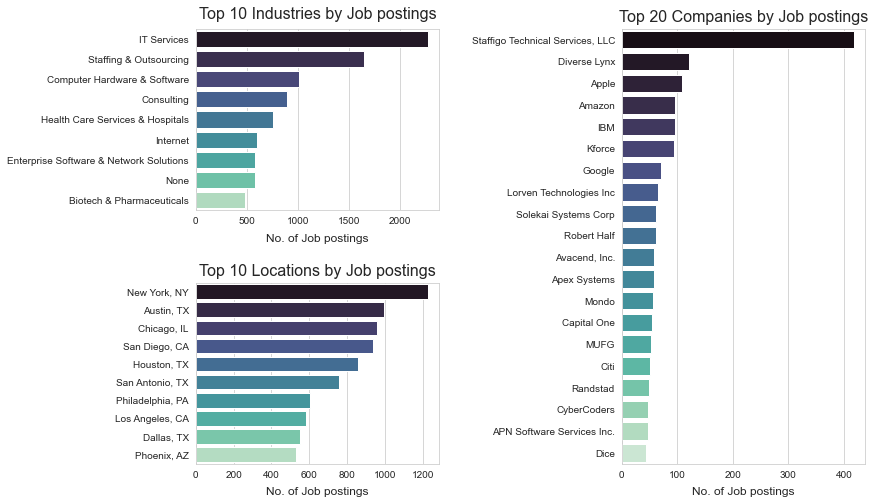

In [36]:
fig = plt.figure(figsize=(12,8))

gs = GridSpec(2, 2, figure=fig, wspace=0.75, hspace=0.4, width_ratios=[1,1])

ax1 = fig.add_subplot(gs[:, 1])
ax2 = fig.add_subplot(gs[0, 0])
ax3 = fig.add_subplot(gs[1, 0])

companies = listings['Company Name'].value_counts()[:20] # Top 20 companies
sns.barplot(companies.values, companies.index, palette='mako', ax=ax1)
ax1.set_title('Top 20 Companies by Job postings', size=16, pad=7)
ax1.set_xlabel('No. of Job postings', fontsize=12, labelpad=7)

industries = listings['Industry'].value_counts()[:10] # Top 10 Industries
industries = industries[industries.index!="-1"]
sns.barplot(industries.values, industries.index, palette='mako', ax=ax2)
ax2.set_title('Top 10 Industries by Job postings', size=16, pad=10)
ax2.set_xlabel('No. of Job postings', fontsize=12, labelpad=7)

locations = listings['Location'].value_counts()[:10] # Top 10 Industries
sns.barplot(locations.values, locations.index, palette='mako', ax=ax3)
ax3.set_title('Top 10 Locations by Job postings', size=16, pad=7)
ax3.set_xlabel('No. of Job postings', fontsize=12, labelpad=7)

plt.show()